# Hyperparameter Tuning Audio Data Embeddings

In [100]:
#Importing the necessary libraries
from functions_audio_model import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import json
import tensorflow as tf
import shutil
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from sklearn.model_selection import ParameterGrid
from torch import nn
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import zoom
from torch.utils.data import Dataset
import torchaudio
import matplotlib.pyplot as plt


Female Model Hyperparameter Tuning

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, labels):
        self.embedding_dir = embedding_dir
        self.file_list = [f for f in os.listdir(embedding_dir) if f.endswith('_w2V2.npy')]
        self.labels = labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file
        base_name = self.file_list[idx].replace('_w2V2.npy', '')

        embedding = np.load(os.path.join(self.embedding_dir, base_name + '_w2V2.npy'))
    
        #label
        label = self.labels[base_name]
        #embedding
        embedding = torch.mean(torch.from_numpy(embedding), dim=1)
        
        return embedding, label

In [41]:
with open('data/audio/embeddingsF_sets/labels_F_val.json', 'r') as file:
    labelsF_val = json.load(file)

with open('data/audio/embeddingsF_sets/labels_F_train.json', 'r') as file:
    labelsF_train = json.load(file)



embeddings_train = 'data/audio/embeddingsF_sets/F_train_set/'
embeddings_val = 'data/audio/embeddingsF_sets/F_val_set/'


# Define the datasets
train_datasetF = EmbeddingDataset(embeddings_train, labelsF_train)
val_datasetF = EmbeddingDataset(embeddings_val, labelsF_val)

In [5]:
#Classifier HEAD
class Classifier(nn.Module):
    def __init__(self, num_classes, in_features):
        super(Classifier, self).__init__()
        #Linear Layer
        self.linear = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


param_grid = {'learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001],
              'batchsize': [4, 8, 16, 32, 64],
              'N_EPOCHS': [20, 30, 40, 50]}


# Store the results
results = []


# Create a parameter grid
grid = ParameterGrid(param_grid)

for params in grid:

    # Create the DataLoaders
    train_dataloader = DataLoader(train_datasetF, batch_size=params['batchsize'])
    val_dataloader = DataLoader(val_datasetF, batch_size=params['batchsize'])


    #Define the loss function
    criterion = nn.CrossEntropyLoss()

    #metrics
    metrics = {'ACC': acc, 'F1-weighted': f1}

    #Definition of the Model HEAD
    #number of features of last layer Wav2Vec2
    num_ftrs = 768

    #Binary Classification -> Sarcasm or not
    num_classes = 2 

    model_head = Classifier(num_classes, num_ftrs)

    # Create the optimizer
    optimizer = torch.optim.AdamW(model_head.parameters(), lr=params['learning_rate'])

    # Train the model
    train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=params['N_EPOCHS'], device=device)

    # Store the results
    results.append({
        'lr': params['learning_rate'],
        'batch_size': params['batchsize'],
        'num_epochs': params['N_EPOCHS'],
        'eval_loss': test_metrics_log[1][-1],
        'eval_acc': test_metrics_log[0][-1]
        })


#Save the results to a JSON file
results_path = 'results/audio_hyperparameters_F.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

Epoch 0 of 20


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


train Loss: 0.7074,  ACC: 0.4749, F1-weighted: 0.3249


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


eval Loss: 0.6757,  ACC: 0.5000, F1-weighted: 0.3322
Epoch 1 of 20


100%|██████████| 9/9 [00:00<00:00, 34.13it/s]


train Loss: 0.6495,  ACC: 0.6501, F1-weighted: 0.5830


100%|██████████| 2/2 [00:00<00:00, 24.83it/s]


eval Loss: 0.6412,  ACC: 0.7188, F1-weighted: 0.7108
Epoch 2 of 20


100%|██████████| 9/9 [00:00<00:00, 39.36it/s]


train Loss: 0.6164,  ACC: 0.7404, F1-weighted: 0.7214


100%|██████████| 2/2 [00:00<00:00, 26.38it/s]


eval Loss: 0.6159,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 3 of 20


100%|██████████| 9/9 [00:00<00:00, 41.25it/s]


train Loss: 0.5913,  ACC: 0.7334, F1-weighted: 0.7163


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]


eval Loss: 0.5960,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 4 of 20


100%|██████████| 9/9 [00:00<00:00, 29.86it/s]


train Loss: 0.5706,  ACC: 0.7404, F1-weighted: 0.7218


100%|██████████| 2/2 [00:00<00:00, 18.15it/s]


eval Loss: 0.5806,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 5 of 20


100%|██████████| 9/9 [00:00<00:00, 21.56it/s]


train Loss: 0.5541,  ACC: 0.7404, F1-weighted: 0.7218


100%|██████████| 2/2 [00:00<00:00, 16.79it/s]


eval Loss: 0.5681,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 6 of 20


100%|██████████| 9/9 [00:00<00:00, 32.16it/s]


train Loss: 0.5413,  ACC: 0.7404, F1-weighted: 0.7218


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


eval Loss: 0.5579,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 7 of 20


100%|██████████| 9/9 [00:00<00:00, 31.19it/s]


train Loss: 0.5315,  ACC: 0.7473, F1-weighted: 0.7289


100%|██████████| 2/2 [00:00<00:00, 20.57it/s]


eval Loss: 0.5495,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 8 of 20


100%|██████████| 9/9 [00:00<00:00, 38.45it/s]


train Loss: 0.5238,  ACC: 0.7559, F1-weighted: 0.7359


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


eval Loss: 0.5427,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 9 of 20


100%|██████████| 9/9 [00:00<00:00, 45.96it/s]


train Loss: 0.5174,  ACC: 0.7489, F1-weighted: 0.7284


100%|██████████| 2/2 [00:00<00:00, 28.86it/s]


eval Loss: 0.5371,  ACC: 0.7188, F1-weighted: 0.7124
Epoch 10 of 20


100%|██████████| 9/9 [00:00<00:00, 36.23it/s]


train Loss: 0.5119,  ACC: 0.7489, F1-weighted: 0.7284


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


eval Loss: 0.5323,  ACC: 0.7500, F1-weighted: 0.7460
Epoch 11 of 20


100%|██████████| 9/9 [00:00<00:00, 31.62it/s]


train Loss: 0.5071,  ACC: 0.7559, F1-weighted: 0.7350


100%|██████████| 2/2 [00:00<00:00, 20.34it/s]


eval Loss: 0.5282,  ACC: 0.7500, F1-weighted: 0.7460
Epoch 12 of 20


100%|██████████| 9/9 [00:00<00:00, 25.98it/s]


train Loss: 0.5029,  ACC: 0.7628, F1-weighted: 0.7418


100%|██████████| 2/2 [00:00<00:00, 35.55it/s]


eval Loss: 0.5246,  ACC: 0.7500, F1-weighted: 0.7460
Epoch 13 of 20


100%|██████████| 9/9 [00:00<00:00, 19.04it/s]


train Loss: 0.4991,  ACC: 0.7628, F1-weighted: 0.7418


100%|██████████| 2/2 [00:00<00:00, 16.29it/s]


eval Loss: 0.5215,  ACC: 0.7500, F1-weighted: 0.7460
Epoch 14 of 20


100%|██████████| 9/9 [00:00<00:00, 29.89it/s]


train Loss: 0.4957,  ACC: 0.7628, F1-weighted: 0.7418


100%|██████████| 2/2 [00:00<00:00, 20.49it/s]


eval Loss: 0.5188,  ACC: 0.7812, F1-weighted: 0.7782
Epoch 15 of 20


100%|██████████| 9/9 [00:00<00:00, 35.71it/s]


train Loss: 0.4925,  ACC: 0.7628, F1-weighted: 0.7418


100%|██████████| 2/2 [00:00<00:00, 23.69it/s]


eval Loss: 0.5164,  ACC: 0.7812, F1-weighted: 0.7782
Epoch 16 of 20


100%|██████████| 9/9 [00:00<00:00, 44.87it/s]


train Loss: 0.4896,  ACC: 0.7698, F1-weighted: 0.7492


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


eval Loss: 0.5142,  ACC: 0.7812, F1-weighted: 0.7782
Epoch 17 of 20


100%|██████████| 9/9 [00:00<00:00, 44.85it/s]


train Loss: 0.4868,  ACC: 0.7698, F1-weighted: 0.7492


100%|██████████| 2/2 [00:00<00:00, 62.16it/s]


eval Loss: 0.5123,  ACC: 0.7812, F1-weighted: 0.7782
Epoch 18 of 20


100%|██████████| 9/9 [00:00<00:00, 41.63it/s]


train Loss: 0.4842,  ACC: 0.7698, F1-weighted: 0.7492


100%|██████████| 2/2 [00:00<00:00, 36.54it/s]


eval Loss: 0.5106,  ACC: 0.7812, F1-weighted: 0.7782
Epoch 19 of 20


100%|██████████| 9/9 [00:00<00:00, 40.94it/s]


train Loss: 0.4817,  ACC: 0.7698, F1-weighted: 0.7492


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


eval Loss: 0.5090,  ACC: 0.7812, F1-weighted: 0.7782


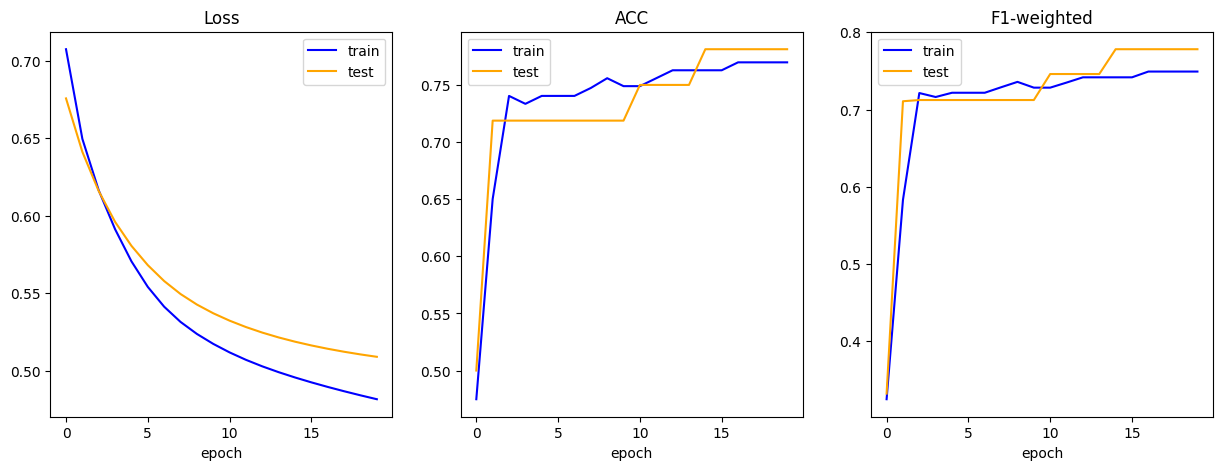

In [51]:
#Final Chosen Model Female

# Results:
# "lr": 0.001,
#         "batch_size": 16,
#         "num_epochs": 20,
#         "eval_loss": 0.7781512605042017,
#         "eval_acc": 0.78125

# Hyperparameters Chosen:
learning_rate = 0.001
batch_size = 16
N_EPOCHS = 20


 # Create the DataLoaders
train_dataloader = DataLoader(train_datasetF, batch_size=batch_size)
val_dataloader = DataLoader(val_datasetF, batch_size=batch_size)

# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

#Definition of the Model HEAD
#number of features of last layer Wav2Vec2
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

model_head = Classifier(num_classes, num_ftrs)

#Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

#Train the model
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model_head.state_dict(), results_models_weights_dir + 'audio_model_embeddingsF.pth')


In [52]:
#Test Set Female for Chosen Model

with open('data/audio/embeddingsF_sets/labels_F_test.json', 'r') as file:
    labelsF_test = json.load(file)

embeddings_test = 'data/audio/embeddingsF_sets/F_test_set/'

test_datasetF = EmbeddingDataset(embeddings_test, labelsF_test)

# Create the test DataLoader
test_dataloader = DataLoader(test_datasetF, batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_metrics = evaluate(model_head, criterion, metrics, test_dataloader, device)

# Print the test loss and metrics
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)

100%|██████████| 2/2 [00:00<00:00,  9.60it/s]

eval Loss: 0.4282,  ACC: 0.8304, F1-weighted: 0.8288
Test loss: 0.42815548181533813
Test metrics: {'ACC': 0.8303571428571428, 'F1-weighted': 0.8288156288156289}


Male Model Hyperparameter Tuning

In [43]:
with open('data/audio/embeddingsM_sets/labels_M_val.json', 'r') as file:
    labelsM_val = json.load(file)

with open('data/audio/embeddingsM_sets/labels_M_train.json', 'r') as file:
    labelsM_train = json.load(file)



embeddings_train_M = 'data/audio/embeddingsM_sets/M_train_set/'
embeddings_val_M = 'data/audio/embeddingsM_sets/M_val_set/'


# Define the datasets
train_datasetM = EmbeddingDataset(embeddings_train_M, labelsM_train)
val_datasetM = EmbeddingDataset(embeddings_val_M, labelsM_val)

In [ ]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


param_grid = {'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
              'batchsize': [8, 16, 32, 64],
              'N_EPOCHS': [20, 30, 40]}


# Store the results
results = []


# Create a parameter grid
grid = ParameterGrid(param_grid)

for params in grid:

    # Create the DataLoaders
    train_dataloader = DataLoader(train_datasetM, batch_size=params['batchsize'])
    val_dataloader = DataLoader(val_datasetM, batch_size=params['batchsize'])


    #Define the loss function
    criterion = nn.CrossEntropyLoss()

    #metrics
    metrics = {'ACC': acc, 'F1-weighted': f1}

    #Definition of the Model HEAD
    #number of features of last layer Wav2Vec2
    num_ftrs = 768

    #Binary Classification -> Sarcasm or not
    num_classes = 2 

    model_head = Classifier(num_classes, num_ftrs)

    # Create the optimizer
    optimizer = torch.optim.AdamW(model_head.parameters(), lr=params['learning_rate'])

    # Train the model
    train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=params['N_EPOCHS'], device=device)

    # Store the results
    results.append({
        'lr': params['learning_rate'],
        'batch_size': params['batchsize'],
        'num_epochs': params['N_EPOCHS'],
        'eval_loss': test_metrics_log[1][-1],         
        'eval_acc': test_metrics_log[0][-1]
        })


#Save the results to a JSON file
results_path = 'results/audio_hyperparameters_M.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

Epoch 0 of 24


100%|██████████| 39/39 [00:02<00:00, 15.28it/s]


train Loss: 0.6853,  ACC: 0.5353, F1-weighted: 0.4377


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


eval Loss: 0.6600,  ACC: 0.6250, F1-weighted: 0.5380
Epoch 1 of 24


100%|██████████| 39/39 [00:03<00:00, 12.63it/s]


train Loss: 0.6574,  ACC: 0.6314, F1-weighted: 0.5921


100%|██████████| 9/9 [00:00<00:00, 12.20it/s]


eval Loss: 0.6383,  ACC: 0.6667, F1-weighted: 0.5747
Epoch 2 of 24


100%|██████████| 39/39 [00:00<00:00, 41.03it/s]


train Loss: 0.6380,  ACC: 0.6410, F1-weighted: 0.6066


100%|██████████| 9/9 [00:00<00:00, 59.14it/s]


eval Loss: 0.6202,  ACC: 0.7083, F1-weighted: 0.6301
Epoch 3 of 24


100%|██████████| 39/39 [00:01<00:00, 20.67it/s]


train Loss: 0.6226,  ACC: 0.6635, F1-weighted: 0.6337


100%|██████████| 9/9 [00:00<00:00, 21.46it/s]


eval Loss: 0.6051,  ACC: 0.7361, F1-weighted: 0.6659
Epoch 4 of 24


100%|██████████| 39/39 [00:00<00:00, 41.20it/s]


train Loss: 0.6096,  ACC: 0.6827, F1-weighted: 0.6469


100%|██████████| 9/9 [00:00<00:00, 28.13it/s]


eval Loss: 0.5920,  ACC: 0.7361, F1-weighted: 0.6659
Epoch 5 of 24


100%|██████████| 39/39 [00:00<00:00, 56.85it/s]


train Loss: 0.5983,  ACC: 0.6891, F1-weighted: 0.6532


100%|██████████| 9/9 [00:00<00:00, 15.22it/s]


eval Loss: 0.5806,  ACC: 0.7500, F1-weighted: 0.6847
Epoch 6 of 24


100%|██████████| 39/39 [00:01<00:00, 21.25it/s]


train Loss: 0.5883,  ACC: 0.6987, F1-weighted: 0.6623


100%|██████████| 9/9 [00:00<00:00, 19.11it/s]


eval Loss: 0.5705,  ACC: 0.7500, F1-weighted: 0.6847
Epoch 7 of 24


100%|██████████| 39/39 [00:02<00:00, 14.66it/s]


train Loss: 0.5793,  ACC: 0.7115, F1-weighted: 0.6751


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


eval Loss: 0.5616,  ACC: 0.7361, F1-weighted: 0.6692
Epoch 8 of 24


100%|██████████| 39/39 [00:02<00:00, 14.58it/s]


train Loss: 0.5712,  ACC: 0.7115, F1-weighted: 0.6740


100%|██████████| 9/9 [00:00<00:00, 45.62it/s]


eval Loss: 0.5536,  ACC: 0.7639, F1-weighted: 0.7327
Epoch 9 of 24


100%|██████████| 39/39 [00:00<00:00, 50.97it/s]


train Loss: 0.5639,  ACC: 0.7115, F1-weighted: 0.6740


100%|██████████| 9/9 [00:00<00:00, 63.68it/s]


eval Loss: 0.5466,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 10 of 24


100%|██████████| 39/39 [00:00<00:00, 89.71it/s]


train Loss: 0.5571,  ACC: 0.7083, F1-weighted: 0.6728


100%|██████████| 9/9 [00:00<00:00, 56.21it/s]


eval Loss: 0.5403,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 11 of 24


100%|██████████| 39/39 [00:00<00:00, 81.16it/s]


train Loss: 0.5509,  ACC: 0.7083, F1-weighted: 0.6745


100%|██████████| 9/9 [00:00<00:00, 63.92it/s]


eval Loss: 0.5347,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 12 of 24


100%|██████████| 39/39 [00:00<00:00, 40.73it/s]


train Loss: 0.5452,  ACC: 0.7115, F1-weighted: 0.6793


100%|██████████| 9/9 [00:00<00:00, 30.98it/s]


eval Loss: 0.5296,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 13 of 24


100%|██████████| 39/39 [00:01<00:00, 25.64it/s]


train Loss: 0.5398,  ACC: 0.7115, F1-weighted: 0.6793


100%|██████████| 9/9 [00:00<00:00, 57.28it/s]


eval Loss: 0.5251,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 14 of 24


100%|██████████| 39/39 [00:01<00:00, 32.82it/s]


train Loss: 0.5348,  ACC: 0.7179, F1-weighted: 0.6856


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


eval Loss: 0.5209,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 15 of 24


100%|██████████| 39/39 [00:01<00:00, 21.93it/s]


train Loss: 0.5302,  ACC: 0.7212, F1-weighted: 0.6885


100%|██████████| 9/9 [00:00<00:00, 55.51it/s]


eval Loss: 0.5172,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 16 of 24


100%|██████████| 39/39 [00:01<00:00, 35.75it/s]


train Loss: 0.5258,  ACC: 0.7244, F1-weighted: 0.6916


100%|██████████| 9/9 [00:00<00:00, 79.61it/s]


eval Loss: 0.5138,  ACC: 0.7778, F1-weighted: 0.7482
Epoch 17 of 24


100%|██████████| 39/39 [00:01<00:00, 25.49it/s]


train Loss: 0.5216,  ACC: 0.7340, F1-weighted: 0.7017


100%|██████████| 9/9 [00:00<00:00, 29.20it/s]


eval Loss: 0.5108,  ACC: 0.7917, F1-weighted: 0.7597
Epoch 18 of 24


100%|██████████| 39/39 [00:00<00:00, 66.96it/s]


train Loss: 0.5177,  ACC: 0.7436, F1-weighted: 0.7130


100%|██████████| 9/9 [00:00<00:00, 54.26it/s]


eval Loss: 0.5080,  ACC: 0.7917, F1-weighted: 0.7597
Epoch 19 of 24


100%|██████████| 39/39 [00:01<00:00, 33.08it/s]


train Loss: 0.5139,  ACC: 0.7468, F1-weighted: 0.7142


100%|██████████| 9/9 [00:00<00:00, 56.99it/s]


eval Loss: 0.5055,  ACC: 0.7917, F1-weighted: 0.7597
Epoch 20 of 24


100%|██████████| 39/39 [00:01<00:00, 32.79it/s]


train Loss: 0.5104,  ACC: 0.7532, F1-weighted: 0.7186


100%|██████████| 9/9 [00:00<00:00, 43.92it/s]


eval Loss: 0.5032,  ACC: 0.7917, F1-weighted: 0.7597
Epoch 21 of 24


100%|██████████| 39/39 [00:00<00:00, 68.90it/s]


train Loss: 0.5070,  ACC: 0.7532, F1-weighted: 0.7186


100%|██████████| 9/9 [00:00<00:00, 48.19it/s]


eval Loss: 0.5011,  ACC: 0.8056, F1-weighted: 0.7738
Epoch 22 of 24


100%|██████████| 39/39 [00:00<00:00, 78.32it/s]


train Loss: 0.5038,  ACC: 0.7596, F1-weighted: 0.7250


100%|██████████| 9/9 [00:00<00:00, 58.38it/s]


eval Loss: 0.4992,  ACC: 0.8056, F1-weighted: 0.7738
Epoch 23 of 24


100%|██████████| 39/39 [00:00<00:00, 78.36it/s]


train Loss: 0.5007,  ACC: 0.7628, F1-weighted: 0.7323


100%|██████████| 9/9 [00:00<00:00, 62.71it/s]


eval Loss: 0.4974,  ACC: 0.8056, F1-weighted: 0.7738


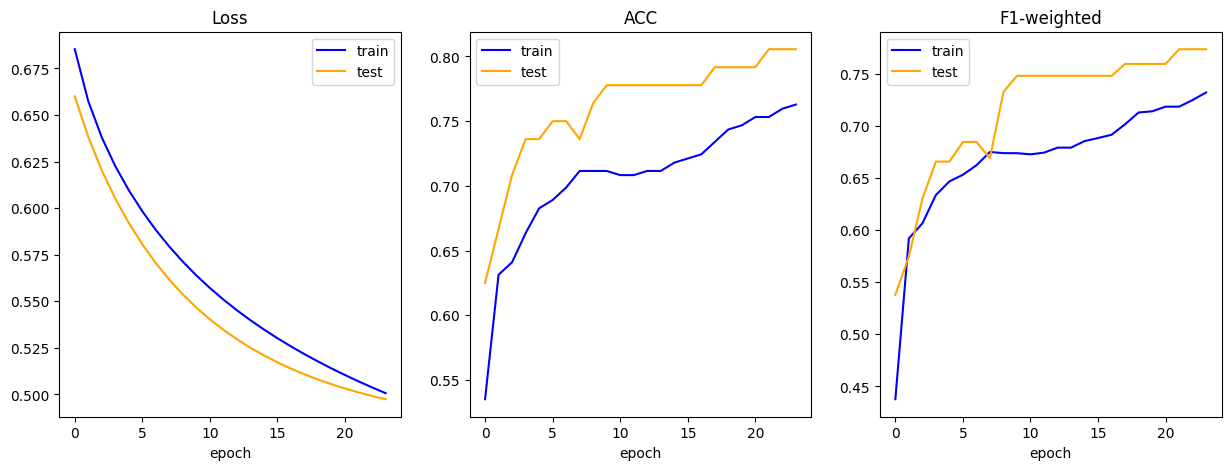

In [53]:
#Final Chosen Model Male

# Seed for reproducibility
torch.manual_seed(42)

#Final Chosen Model Male:
    #   "lr": 0.001,
    #     "batch_size": 8,
    #     "num_epochs": 40,
    #     "eval_loss": 0.7434978601645269,
    #     "eval_acc": 0.7777777777777778

# Hyperparameters Chosen:
learning_rate = 0.001
batch_size = 8
N_EPOCHS = 24


 # Create the DataLoaders
train_dataloader = DataLoader(train_datasetM, batch_size=batch_size)
val_dataloader = DataLoader(val_datasetM, batch_size=batch_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

#Definition of the Model HEAD
#number of features of last layer Wav2Vec2
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

model_head = Classifier(num_classes, num_ftrs)

#Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

#Train the model
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model_head.state_dict(), results_models_weights_dir + 'audio_model_embeddingsM.pth')


In [54]:
#Test Set Male for Chosen Model

with open('data/audio/embeddingsM_sets/labels_M_test.json', 'r') as file:
    labelsM_test = json.load(file)

embeddings_test = 'data/audio/embeddingsM_sets/M_test_set/'

test_datasetM = EmbeddingDataset(embeddings_test, labelsM_test)

# Create the test DataLoader
test_dataloader = DataLoader(test_datasetM, batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_metrics = evaluate(model_head, criterion, metrics, test_dataloader, device)

# Print the test loss and metrics
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)

100%|██████████| 9/9 [00:00<00:00, 29.75it/s]

eval Loss: 0.4923,  ACC: 0.7639, F1-weighted: 0.7539
Test loss: 0.49226992660098606
Test metrics: {'ACC': 0.7638888888888888, 'F1-weighted': 0.7538560205226872}


Mixed Model Hyperparameter Tuning

In [46]:
with open('data/audio/embeddingsmixed_sets/labels_mixed_val.json', 'r') as file:
    labelsmixed_val = json.load(file)

with open('data/audio/embeddingsmixed_sets/labels_mixed_train.json', 'r') as file:
    labelsmixed_train = json.load(file)


embeddings_train = 'data/audio/embeddingsmixed_sets/mixed_train_set/'
embeddings_val = 'data/audio/embeddingsmixed_sets/mixed_val_set/'

# Define the datasets
train_datasetmixed = EmbeddingDataset(embeddings_train, labelsmixed_train)
val_datasetmixed = EmbeddingDataset(embeddings_val, labelsmixed_val)

In [ ]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


param_grid = {'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
              'batchsize': [8, 16, 32, 64],
              'N_EPOCHS': [20, 30, 40]}


# Store the results
results = []


# Create a parameter grid
grid = ParameterGrid(param_grid)

for params in grid:

    # Create the DataLoaders
    train_dataloader = DataLoader(train_datasetmixed, batch_size=params['batchsize'])
    val_dataloader = DataLoader(val_datasetmixed, batch_size=params['batchsize'])


    #Define the loss function
    criterion = nn.CrossEntropyLoss()

    #metrics
    metrics = {'ACC': acc, 'F1-weighted': f1}

    #Definition of the Model HEAD
    #number of features of last layer Wav2Vec2
    num_ftrs = 768

    #Binary Classification -> Sarcasm or not
    num_classes = 2 

    model_head = Classifier(num_classes, num_ftrs)

    # Create the optimizer
    optimizer = torch.optim.AdamW(model_head.parameters(), lr=params['learning_rate'])

    # Train the model
    train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=params['N_EPOCHS'], device=device)

    # Store the results
    results.append({
        'lr': params['learning_rate'],
        'batch_size': params['batchsize'],
        'num_epochs': params['N_EPOCHS'],
        'eval_loss': test_metrics_log[1][-1],         
        'eval_acc': test_metrics_log[0][-1]
        })


#Save the results to a JSON file
results_path = 'results/audio_hyperparameters_mixed.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

Epoch 0 of 8


100%|██████████| 19/19 [00:02<00:00,  8.41it/s]


train Loss: 0.6366,  ACC: 0.6447, F1-weighted: 0.6106


100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


eval Loss: 0.6246,  ACC: 0.7562, F1-weighted: 0.7503
Epoch 1 of 8


100%|██████████| 19/19 [00:00<00:00, 32.68it/s]


train Loss: 0.5656,  ACC: 0.7034, F1-weighted: 0.6962


100%|██████████| 5/5 [00:00<00:00, 31.62it/s]


eval Loss: 0.5900,  ACC: 0.7312, F1-weighted: 0.7144
Epoch 2 of 8


100%|██████████| 19/19 [00:00<00:00, 31.93it/s]


train Loss: 0.5345,  ACC: 0.7237, F1-weighted: 0.7148


100%|██████████| 5/5 [00:00<00:00, 13.88it/s]


eval Loss: 0.5842,  ACC: 0.7500, F1-weighted: 0.7383
Epoch 3 of 8


100%|██████████| 19/19 [00:00<00:00, 30.73it/s]


train Loss: 0.5151,  ACC: 0.7379, F1-weighted: 0.7301


100%|██████████| 5/5 [00:00<00:00, 27.42it/s]


eval Loss: 0.5781,  ACC: 0.7562, F1-weighted: 0.7443
Epoch 4 of 8


100%|██████████| 19/19 [00:00<00:00, 30.21it/s]


train Loss: 0.5035,  ACC: 0.7560, F1-weighted: 0.7489


100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


eval Loss: 0.5782,  ACC: 0.7688, F1-weighted: 0.7608
Epoch 5 of 8


100%|██████████| 19/19 [00:00<00:00, 30.14it/s]


train Loss: 0.4928,  ACC: 0.7626, F1-weighted: 0.7560


100%|██████████| 5/5 [00:00<00:00, 24.41it/s]


eval Loss: 0.5770,  ACC: 0.7688, F1-weighted: 0.7608
Epoch 6 of 8


100%|██████████| 19/19 [00:00<00:00, 30.76it/s]


train Loss: 0.4842,  ACC: 0.7659, F1-weighted: 0.7590


100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


eval Loss: 0.5768,  ACC: 0.7750, F1-weighted: 0.7667
Epoch 7 of 8


100%|██████████| 19/19 [00:00<00:00, 20.22it/s]


train Loss: 0.4767,  ACC: 0.7774, F1-weighted: 0.7710


100%|██████████| 5/5 [00:00<00:00, 26.71it/s]


eval Loss: 0.5765,  ACC: 0.7812, F1-weighted: 0.7747


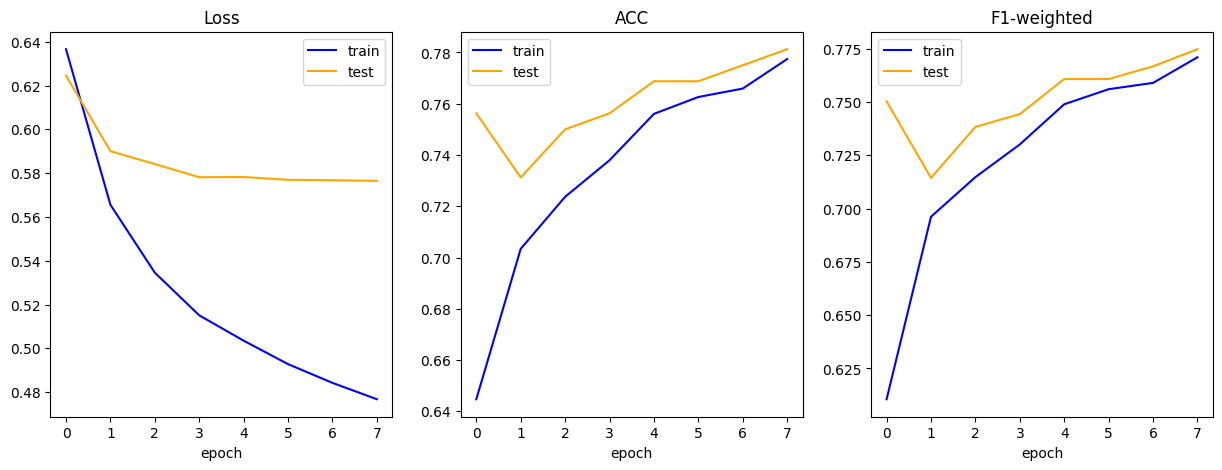

In [55]:
#Final Chosen Model Mixed

# Seed for reproducibility
torch.manual_seed(42)

#Final Chosen Model Mixed:
#  {
#         "lr": 1e-05,
#         "batch_size": 64,
#         "num_epochs": 30,
#         "eval_loss": 0.7726955585119467,
#         "eval_acc": 0.7760416666666666
#     },

# {
#         "lr": 0.01,
#         "batch_size": 32,
#         "num_epochs": 20,
#         "eval_loss": 0.7704861665267344,
#         "eval_acc": 0.775
#     },

# Hyperparameters Chosen:
learning_rate = 0.01
batch_size = 32
N_EPOCHS = 8


 # Create the DataLoaders
train_dataloader = DataLoader(train_datasetmixed, batch_size=batch_size)
val_dataloader = DataLoader(val_datasetmixed, batch_size=batch_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

#Definition of the Model HEAD
#number of features of last layer Wav2Vec2
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

model_head = Classifier(num_classes, num_ftrs)

#Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

#Train the model
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model_head.state_dict(), results_models_weights_dir + 'audio_model_embeddingsmixed.pth')



In [57]:
#Test Set Mixed for Chosen Model

with open('data/audio/embeddingsmixed_sets/labels_mixed_test.json', 'r') as file:
    labelsmixed_test = json.load(file)

embeddings_test = 'data/audio/embeddingsmixed_sets/mixed_test_set/'

test_datasetmixed = EmbeddingDataset(embeddings_test, labelsmixed_test)

# Create the test DataLoader
test_dataloader = DataLoader(test_datasetmixed, batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_metrics = evaluate(model_head, criterion, metrics, test_dataloader, device)

# Print the test loss and metrics
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)

100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

eval Loss: 0.5004,  ACC: 0.7937, F1-weighted: 0.7887
Test loss: 0.5003714680671691
Test metrics: {'ACC': 0.79375, 'F1-weighted': 0.7886726742414348}


Cross Validation:

In [71]:
results_cross = {}

Female Model:

In [75]:
#FEMALE MODEL
#MALE ON FEMALE Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 16

# Load the state dictionary
model_F = Classifier(num_classes, num_ftrs)
model_F.load_state_dict(torch.load('models_weights/audio_model_embeddingsF.pth'))


with open('data/audio/labels_M.json', 'r') as file:
    labels_M = json.load(file)

embeddings_test = 'data/audio/embeddingsM/'

test_datasetM = EmbeddingDataset(embeddings_test,labels_M)

# Create the test DataLoader
test_dataloaderM = DataLoader(test_datasetM, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_F, criterion, metrics, test_dataloaderM, device)



# Store the results
results_cross['Male dataset on Female Model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:01<00:00, 19.58it/s]

eval Loss: 0.7114,  ACC: 0.5938, F1-weighted: 0.5670


In [73]:
#FEMALE MODEL
#Mixed ON FEMALE Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 16

# Load the state dictionary
model_F = Classifier(num_classes, num_ftrs)
model_F.load_state_dict(torch.load('models_weights/audio_model_embeddingsmixed.pth'))


with open('data/audio/labels_mixed.json', 'r') as file:
    labels_mixed = json.load(file)

embeddings_test = 'data/audio/embeddingsmixed/'

test_datasetmixed = EmbeddingDataset(embeddings_test,labels_mixed)

# Create the test DataLoader
test_dataloaderM = DataLoader(test_datasetmixed, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_F, criterion, metrics, test_dataloaderM, device)


results_cross = {}
# Store the results
results_cross['Mixed dataset on Female model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:02<00:00, 22.81it/s]

eval Loss: 0.5018,  ACC: 0.7508, F1-weighted: 0.7312


In [76]:
results_cross

{'Mixed dataset on Female model': {'Test loss': 0.5018006695641412,
  'Test metrics': {'ACC': 0.7507716049382716,
   'F1-weighted': 0.7311950745868503}},
 'Male dataset on Female Model': {'Test loss': 0.7113848254084587,
  'Test metrics': {'ACC': 0.59375, 'F1-weighted': 0.5670007242867702}}}

Male Model Cross:

In [78]:
#Male MODEL
#Female ON Male Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 8

# Load the state dictionary
model_M = Classifier(num_classes, num_ftrs)
model_M.load_state_dict(torch.load('models_weights/audio_model_embeddingsM.pth'))


with open('data/audio/labels_F.json', 'r') as file:
    labels_F = json.load(file)

embeddings_test = 'data/audio/embeddingsF/'

test_datasetF = EmbeddingDataset(embeddings_test,labels_F)

# Create the test DataLoader
test_dataloaderM = DataLoader(test_datasetF, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_M, criterion, metrics, test_dataloaderM, device)



# Store the results
results_cross['Female dataset on Male Model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

100%|██████████| 26/26 [00:00<00:00, 44.14it/s]

eval Loss: 0.6500,  ACC: 0.6522, F1-weighted: 0.5759


In [82]:
#Male MODEL
#Mixed on Male Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 8

# Load the state dictionary
model_M = Classifier(num_classes, num_ftrs)
model_M.load_state_dict(torch.load('models_weights/audio_model_embeddingsM.pth'))


with open('data/audio/labels_mixed.json', 'r') as file:
    labels_mixed = json.load(file)

embeddings_test = 'data/audio/embeddingsmixed/'

test_datasetmixed = EmbeddingDataset(embeddings_test, labels_mixed)

# Create the test DataLoader
test_dataloadermixed = DataLoader(test_datasetmixed, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_M, criterion, metrics, test_dataloadermixed, device)


# Store the results
results_cross['Mixed dataset on Male Model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

  0%|          | 0/108 [00:00<?, ?it/s]

100%|██████████| 108/108 [00:02<00:00, 43.18it/s]

eval Loss: 0.6433,  ACC: 0.6782, F1-weighted: 0.6214


In [80]:
results_cross

{'Mixed dataset on Female model': {'Test loss': 0.5018006695641412,
  'Test metrics': {'ACC': 0.7507716049382716,
   'F1-weighted': 0.7311950745868503}},
 'Male dataset on Female Model': {'Test loss': 0.7113848254084587,
  'Test metrics': {'ACC': 0.59375, 'F1-weighted': 0.5670007242867702}},
 'Female dataset on Male Model': {'Test loss': 0.6500158539185157,
  'Test metrics': {'ACC': 0.6522435897435896,
   'F1-weighted': 0.5758783951091643}},
 'Mixed dataset on Male Model': {'Test loss': 0.6433091169154203,
  'Test metrics': {'ACC': 0.6782407407407407,
   'F1-weighted': 0.6214435769991328}}}

Mixed Model:

In [81]:
#Mixed MODEL
#Female on Mixed Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 32

# Load the state dictionary
model_mixed = Classifier(num_classes, num_ftrs)
model_mixed.load_state_dict(torch.load('models_weights/audio_model_embeddingsmixed.pth'))


with open('data/audio/labels_F.json', 'r') as file:
    labels_F = json.load(file)

embeddings_test = 'data/audio/embeddingsF/'

test_datasetF = EmbeddingDataset(embeddings_test, labels_F)

# Create the test DataLoader
test_dataloaderF = DataLoader(test_datasetF, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_mixed, criterion, metrics, test_dataloaderF, device)


# Store the results
results_cross['Female dataset on Mixed Model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

100%|██████████| 7/7 [00:00<00:00, 15.25it/s]

eval Loss: 0.5128,  ACC: 0.7520, F1-weighted: 0.7490


In [83]:
#Mixed MODEL
#Male on Mixed Model

# Set seed for reproducibility
torch.manual_seed(42)

batch_size = 32

# Load the state dictionary
model_mixed = Classifier(num_classes, num_ftrs)
model_mixed.load_state_dict(torch.load('models_weights/audio_model_embeddingsmixed.pth'))


with open('data/audio/labels_M.json', 'r') as file:
    labels_M = json.load(file)

embeddings_test = 'data/audio/embeddingsM/'

test_datasetM = EmbeddingDataset(embeddings_test, labels_M)

# Create the test DataLoader
test_dataloaderM = DataLoader(test_datasetM, batch_size=batch_size)

# Evaluate the model
test_loss, test_metrics = evaluate(model_mixed, criterion, metrics, test_dataloaderM, device)


# Store the results
results_cross['Male dataset on Mixed Model'] = {'Test loss': test_loss, 'Test metrics': test_metrics}

100%|██████████| 14/14 [00:01<00:00, 11.03it/s]

eval Loss: 0.6036,  ACC: 0.6719, F1-weighted: 0.6523


In [85]:
results_cross

{'Mixed dataset on Female model': {'Test loss': 0.5018006695641412,
  'Test metrics': {'ACC': 0.7507716049382716,
   'F1-weighted': 0.7311950745868503}},
 'Male dataset on Female Model': {'Test loss': 0.7113848254084587,
  'Test metrics': {'ACC': 0.59375, 'F1-weighted': 0.5670007242867702}},
 'Female dataset on Male Model': {'Test loss': 0.6500158539185157,
  'Test metrics': {'ACC': 0.6522435897435896,
   'F1-weighted': 0.5758783951091643}},
 'Mixed dataset on Male Model': {'Test loss': 0.6433091169154203,
  'Test metrics': {'ACC': 0.6782407407407407,
   'F1-weighted': 0.6214435769991328}},
 'Male dataset on Mixed Model': {'Test loss': 0.6036220107759748,
  'Test metrics': {'ACC': 0.671875, 'F1-weighted': 0.65230530534415}}}

# Final Results for Histogram
Acc(Set/Model)
Validation Accuracy:

## Female Dataset:
Acc(F/F): 0.8304
Acc(F/M): 0.6522
Acc(F/mixed): 0.7520


## Male Dataset:
Acc(M/F): 0.5938
Acc(M/M): 0.8056
Acc(M/mixed):0.6719

## Mixed Dataset:
Acc(mixed/F): 0.7508
Acc(mixed/M): 0.6782
Acc(mixed/mixed): 0.79375

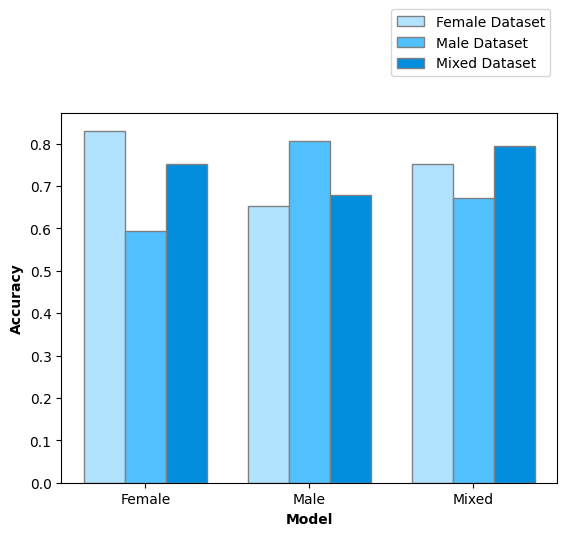

In [99]:
#Histogram for the Audio Model
models = ['Female', 'Male', 'Mixed']
accuracies_FemaleDataset = [0.8304, 0.6522, 0.7520]  # Accuracies on Female Dataset
accuracies_MaleDataset = [0.5938, 0.8056, 0.6719]  # Accuracies on Male Dataset
accuracies_MixedDataset = [0.7508, 0.6782, 0.79375]  # Accuracies on Mixed Dataset

bar_width = 0.25

r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, accuracies_FemaleDataset, width=bar_width, color='#B1E3FF', edgecolor='grey', label='Female Dataset')
plt.bar(r2, accuracies_MaleDataset, width=bar_width, color='#50C0FF', edgecolor='grey', label='Male Dataset')
plt.bar(r3, accuracies_MixedDataset, width=bar_width, color = '#028EDD', edgecolor='grey', label='Mixed Dataset')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Accuracy', fontweight='bold') 

plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3))

plt.savefig('data/audio/histogram_embeddings.svg', format='svg', bbox_inches='tight')

plt.show()

# Final Results for Histogram Text
Acc(Set/Model)
Validation Accuracy:

## Female Dataset:
Acc(F/F): 
Acc(F/M): 
Acc(F/mixed):


## Male Dataset:
Acc(M/F):
Acc(M/M): 0.7240
Acc(M/mixed):

## Mixed Dataset:
Acc(mixed/F): 
Acc(mixed/M):
Acc(mixed/mixed): 0.8507

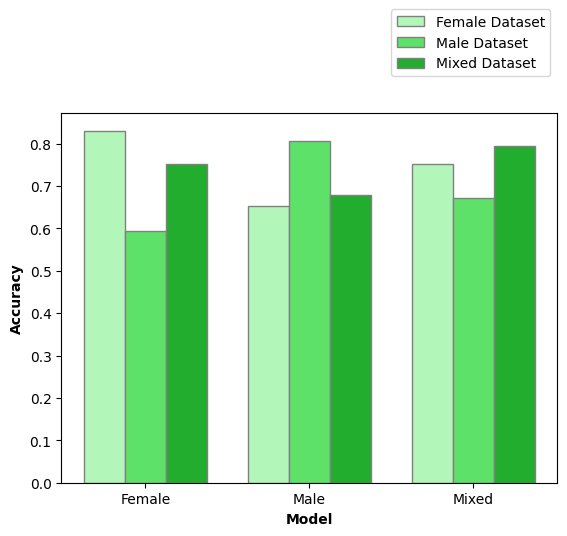

In [101]:
#Histogram Creation for the Text Model
models = ['Female', 'Male', 'Mixed']
accuracies_FemaleDataset = [0.8304, 0.6522, 0.7520]  # Accuracies on Female Dataset
accuracies_MaleDataset = [0.5938, 0.8056, 0.6719]  # Accuracies on Male Dataset
accuracies_MixedDataset = [0.7508, 0.6782, 0.79375]  # Accuracies on Mixed Dataset

bar_width = 0.25

r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, accuracies_FemaleDataset, width=bar_width, color='#B3F6B9', edgecolor='grey', label='Female Dataset')
plt.bar(r2, accuracies_MaleDataset, width=bar_width, color='#5EE169', edgecolor='grey', label='Male Dataset')
plt.bar(r3, accuracies_MixedDataset, width=bar_width, color = '#23AD2E', edgecolor='grey', label='Mixed Dataset')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Accuracy', fontweight='bold') 

plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3))

plt.savefig('data/audio/histogram_embeddings.svg', format='svg', bbox_inches='tight')

plt.show()